In [8]:
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [9]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL_Y = 0.12  # gravity constant in Y direction
GRAVITY_ACCEL_X =0.
BOOST_ACCEL = 0.18  # thrust constant

In [10]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = thrust 
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... @cc antantantant (Prof Max Yi Ren)

        delta_state_gravity = torch.tensor([0., 0.,-GRAVITY_ACCEL_X * FRAME_TIME, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])

        # Thrust for N initial state
        # N = len(state)
        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 2] = torch.cos(state[0, 4])
        state_tensor[0, 3] = torch.sin(state[0, 4])
    
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),(action[0, 1]).reshape(-1, 1)) 
     

        state = state + delta_state  + delta_state_gravity + delta_state_theta 
       
       
        # Update state
        step_matrix = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1.,0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        state = torch.matmul(step_matrix, state.T)
            

        return state.T

In [27]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())
           

    def forward(self, state):
        action = self.network(state)
        action = 2*action - torch.tensor([0, 1])  # bound theta_dot range -1 to 1
        return action

In [12]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # state = [1., 0.]  # TODO: need batch of initial states
        state = [[1.,1.,0.,0.,0.]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)

In [64]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        # self.optimizer = optim.SGD(self.parameters, lr=0.01)
        # optim.Adam
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    

    def train(self, epochs):
        l = np.zeros(epochs)
        for epoch in range(epochs):
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            
        plt.plot(list(range(epochs)), l, color = "r")
            
        plt.title('Convergence Curve')
        plt.xlabel(' Iteration for training')
        plt.ylabel('Error')
        plt

        plt.show()
        self.visualize()
        
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        plt.plot(x, y, color="r")
        plt.title("X postion with respect to Y ")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        plt.plot(vx, y, color="r")
        plt.xlabel('vx')
        plt.ylabel('y')
        plt.show()
        plt.plot(vy, y, color="r")
        plt.xlabel('vy')
        plt.ylabel('y')
        plt.show()
        plt.plot(theta, y, color="r")
        plt.xlabel('theta')
        plt.ylabel('y')
        plt.show()

        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        theta_dot = action_data[:,0]

[1] loss: 9.028
[2] loss: 6.640
[3] loss: 5.172
[4] loss: 4.126
[5] loss: 3.026
[6] loss: 1.588
[7] loss: 0.842
[8] loss: 0.503
[9] loss: 0.304
[10] loss: 0.190
[11] loss: 0.122
[12] loss: 0.076
[13] loss: 0.046
[14] loss: 0.028
[15] loss: 0.017
[16] loss: 0.010
[17] loss: 0.006
[18] loss: 0.004
[19] loss: 0.002
[20] loss: 0.002
[21] loss: 0.001
[22] loss: 0.001
[23] loss: 0.000
[24] loss: 0.000
[25] loss: 0.000


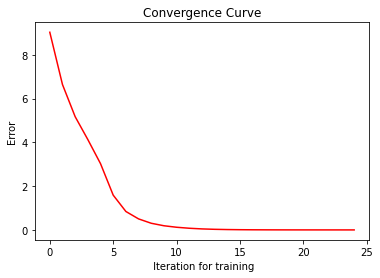

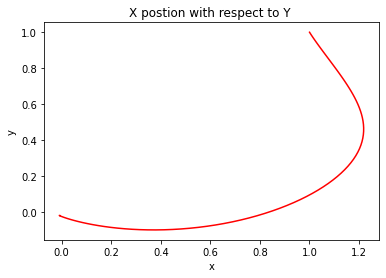

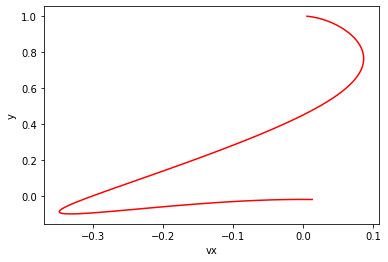

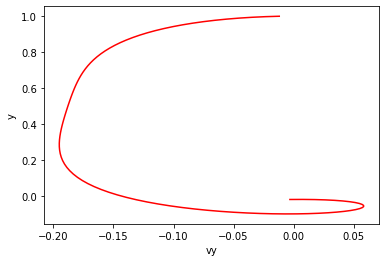

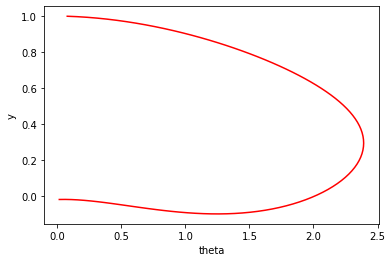

In [67]:
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(25)  # training with number of epochs